# Introduction

**B**ayesian **I**nferential **R**egression for **D**ifferential **M**icrobiome **A**nalysis (BIRDMAn) is a WIP tool for flexible differential abundance analysis through Bayesian inference. BIRDMAn is unique in that it has been designed to support custom statistical modelling. Other tools implement specific models designed for general use cases. BIRDMAn, on the other hand, makes use of the [Stan](https://mc-stan.org/) probabilistic programming language for model specification. The overall goal of this software is to allow users to specify their own statistical models to address their individual experimental design/questions.

BIRDMAn also includes several default models for those who do not wish to tinker with custom Stan models. In this demo notebook, we'll walkthrough fitting the default Negative Binomial model to some example data. For more information see Jamie's [blogpost](https://mortonjt.github.io/probable-bug-bytes/probable-bug-bytes/differential-abundance/) that inspired this project.

**NOTE:** BIRDMAn is still in development and things are likely to change.

# Preprocessing feature table

We will be using data from the study "Responses of gut microbiota to diet composition and weight loss in lean and obese mice" (Qiita ID: 107). This study looks at the effect of weight loss and diet composition on the gut microbiome.

We will first process and explore the raw data.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import biom

raw_tbl = biom.load_table("../data/lean_obese_mice/44773_otu_table.biom")
raw_tbl

1932 x 29 <class 'biom.table.Table'> with 9055 nonzero entries (16% dense)

In [3]:
raw_tbl_df = raw_tbl.to_dataframe()
raw_tbl_df.iloc[:5, :5]

,107.CM04,107.CM10,107.CM19,107.CM23,107.CM28
206494,1.0,3.0,14.0,5.0,1.0
261725,0.0,0.0,0.0,0.0,0.0
276620,2.0,9.0,2.0,2.0,0.0
296165,2.0,0.0,0.0,0.0,0.0
389067,0.0,0.0,0.0,0.0,0.0


For this demo we are going to use a small subset of the OTUs present in this table based on prevalence (present in at least 20 samples). This is done primarily to let the models run quickly.

In [4]:
prev = raw_tbl_df.clip(upper=1).sum(axis=1)
filt_tbl_df = raw_tbl_df.loc[prev[prev >= 20].index, :]
filt_tbl_df.shape

(77, 29)

BIRDMAn expects tables to be input in BIOM format so we save our filtered table in this format.

In [5]:
filt_tbl = biom.table.Table(
    filt_tbl_df.values,
    sample_ids=filt_tbl_df.columns,
    observation_ids=filt_tbl_df.index
)
filt_tbl

77 x 29 <class 'biom.table.Table'> with 1789 nonzero entries (80% dense)

# Exploring metadata

Given the title of this study, we are going to be focused on weight loss and diet as covariates in our model.

In [6]:
import pandas as pd

metadata = pd.read_csv(
    "../data/lean_obese_mice/107_20180101-113755.txt",
    sep="\t",
    index_col=0
)
metadata.index = metadata.index.astype(str)
metadata.head()

,adiponectin,altitude,anonymized_name,b_cell_function_measure,body_habitat,body_product,body_site,body_weight,cd11c,collection_date,...,saa3,sample_type,slc25a,t3,t4,title,tnfa,total_ee,total_number_of_synapses,treatment
sample_name,,,,,,,,,,,,,,,,,,,,,
107.CM01,44.03,0,sample01,154.5,UBERON:feces,UBERON:feces,UBERON:feces,30.6,0.60,11/8/11,...,0.08,XXQIITAXX,0.85,72.86,45.06,Leptin levels correlate with the composition o...,1.51,10.60,23.29,Weight Reduced
107.CM02,44.16,0,sample09,200.6,UBERON:feces,UBERON:feces,UBERON:feces,52.0,1.86,11/8/11,...,1.62,XXQIITAXX,1.07,13.60,33.96,Leptin levels correlate with the composition o...,1.30,13.80,NaN,Ad Lib
107.CM03,39.17,0,sample02,133.3,UBERON:feces,UBERON:feces,UBERON:feces,29.3,1.01,11/8/11,...,0.10,XXQIITAXX,1.14,7.76,45.12,Leptin levels correlate with the composition o...,1.82,10.23,18.40,Weight Reduced
107.CM04,23.55,0,sample03,280.7,UBERON:feces,UBERON:feces,UBERON:feces,36.1,0.53,11/8/11,...,2.24,XXQIITAXX,1.01,15.30,57.87,Leptin levels correlate with the composition o...,1.17,11.70,19.06,Weight Reduced
107.CM05,28.33,0,sample10,472.9,UBERON:feces,UBERON:feces,UBERON:feces,52.9,1.14,11/8/11,...,3.83,XXQIITAXX,1.55,33.46,52.03,Leptin levels correlate with the composition o...,0.62,16.06,26.44,Ad Lib


In [7]:
metadata.groupby(["diet", "treatment"]).size()

diet     treatment     
Control  Ad Lib            8
         Weight Reduced    8
DIO      Ad Lib            7
         Weight Reduced    8
dtype: int64

We will consider diet, treatment, and their interaction in our regression model. Importantly, we will specify that we want to keep `Control` and `Ad Lib` as the respective reference values (same way as in Songbird).

# Running BIRDMAn

Now it's time to run BIRDMAn! To save on computation time we will only specify 100 iterations per chain. For actual modelling you will likely want this value to be higher (defaults to 500).

Every BIRDMAn takes several parameters that I will outline here:

* `table`: BIOM table of features x samples
* `formula`: Formula with which to fit model (same as in Songbird)
* `metadata`: DataFrame with columns specified in `formula`
* `num_iter`: Number of iterations of MCMC sampling to run *per chain*
* `chains`: Number of chains to run

For the default Negative Binomial model we can also include the prior values for $\beta$ and $\phi$.

In [8]:
from birdman import NegativeBinomial

nb = NegativeBinomial(
    table=filt_tbl,
    formula="C(diet, Treatment('Control'))*C(treatment, Treatment('Ad Lib'))",
    metadata=metadata,
    num_iter=100,
    chains=4,
    beta_prior=5.0,
    cauchy_scale=5.0
)

The Stan model must be compiled before fitting. This should only have to be done once *per model type*. So the second time you use the default `NegativeBinomial` model it will not have to compile.

In [9]:
nb.compile_model()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/gibs/projects/birdman/birdman/templates/negative_binomial


Finally, we'll fit the model to our data. This should take ~15-20 seconds.

In [10]:
%%time

nb.fit_model()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


CPU times: user 326 ms, sys: 57.2 ms, total: 383 ms
Wall time: 19.9 s


## Data structure for model

BIRDMAn makes heavy use of the `arviz` package for downstream analysis (see [documentation](https://arviz-devs.github.io/arviz/index.html)). We provide a wrapper function `to_inference_object` to make this relatively easy.

This function wraps much of the functionality of `xarray` for multi-dimensional arrays (see [documentation](http://xarray.pydata.org/en/stable/)). The primary things you have to learn are the `coords` and `dims` system of indexing data.

* `dims` corresponds to the dimensionality of the data. In our example, the $\beta$ parameter is of dimension (number of covariates x number of features), while the $\phi$ over-dispersion parameter is only of dimension (feature).
* `coords` provides the labels for each of the dimensions in `dims`. In this case, we want to specify the name of each covariate and each feature. BIRDMAn saves both of these values as `colnames` and `feature_names` respectively.

We also specify that $\beta$ parameters are currently in *ALR* coordinates. This means that for an input dataset of $N$ microbes, we only have $N-1$ microbes. To address this, we specify that we want the $\beta$ variable to be transformed into *CLR* coordinates to "get back" the microbe we lost.

Finally, the last three arguments to this function specify that we want to include several things in the inference object:

* `posterior_predictive`: If we tried to predict the feature table entries using the fitted parameters (we do this automatically in the default model) then we can use these values downstream for diagnosing the model. The value for this argument should be the name of the Stan variable containing this information (`y_predict` by default).
* `log_likelihood`: We also calculated the log-likelihood values to figure out the best parameter estimates. We can use these values for diagnosis as well. The value for this argument should be the name of the Stan variable containing this information (`log_lik` by default).
* `include_observed_data`: This argument specifies whether or not to include the original table values in the inference object. We can use these "truth" values to compare our model performance.

In [11]:
inference = nb.to_inference_object(
    params=["beta", "phi"],
    coords={
        "feature": nb.feature_names,
        "covariate": nb.colnames
    },
    dims={
        "beta": ["covariate", "feature"],
        "phi": ["feature"]
    },
    alr_params=["beta"],
    posterior_predictive="y_predict",
    log_likelihood="log_lik",
    include_observed_data=True
)

# Diagnosing our fitted model

As with Songbird (or any regression/ML procedure) we want to diagnose our model to make sure we are extracting useful signal and not simply overfitting predictive power. There are a number of ways to do this.

We include an easy to use function to give an *initial* diagnosis for model fit.

In [12]:
nb.diagnose();

INFO:cmdstanpy:Processing csv files: /var/folders/1c/vd4s85fn44q78l5vrmmwn06c0000gn/T/tmp3i1k8rgc/negative_binomial-202103251608-1-8bj7g6_d.csv, /var/folders/1c/vd4s85fn44q78l5vrmmwn06c0000gn/T/tmp3i1k8rgc/negative_binomial-202103251608-2-gfeyg8il.csv, /var/folders/1c/vd4s85fn44q78l5vrmmwn06c0000gn/T/tmp3i1k8rgc/negative_binomial-202103251608-3-0j4vkp22.csv, /var/folders/1c/vd4s85fn44q78l5vrmmwn06c0000gn/T/tmp3i1k8rgc/negative_binomial-202103251608-4-pd54z3la.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  log_lik[25,19]
Such high values indicate incomplete mixing and biasedestimation.
You should consider regularizating your model with additional prior information or a 

We have one warning of an $\hat{R}$ value greater than 1.05. This is not a huge deal considering the number of parameters we are computing.

## LOO

Next we look at the Pareto-smoothed Importance Sampling Leave-One-Out Cross-Validation (PSIS-LOO-CV). This is a mouthful but the core of it is that we want to cross-validate our model to make sure we are not overfitting. This can be fairly computationally expensive for Bayesian models so we use an estimation developed by Aki Vehtari and others. This way we can estimate model performance *from the existing sample draws*.

See these two papers for more information:

* https://arxiv.org/abs/1507.04544
* https://arxiv.org/abs/1507.02646

**Note:** This function requires that you calculated the `log likelihood` values in your Stan code (done by the default Negative Binomial model) and passed them to the inference object.

In [14]:
import birdman.diagnostics as diag

diag.loo(inference, pointwise=True)

Computed from 400 by 2233 log-likelihood matrix

         Estimate       SE
elpd_loo -8081.02   105.56
p_loo      345.23        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2031   91.0%
 (0.5, 0.7]   (ok)        137    6.1%
   (0.7, 1]   (bad)        60    2.7%
   (1, Inf)   (very bad)    5    0.2%

Log likelihood is calculated for each entry in your input table - essentially figuring out how likely is the table value given the estimated parameters. We want to maximize the `elpd_loo` entry. In this demonstration we also calculate the *pointwise* predictive accuracy. We want to see the majority of the Pareto k diagnostic values < 0.7. If there are a lot of values above 0.7 this is indicative of a relatively poor model.

## $\hat{R}$ convergence

Another diagnostic tool is making sure your chains are converging. This can be done by checking the $\hat{R}$ values of your fitted parameters. In a nutshell, these values should be extremely close to 1 to ensure convergence.

See [this link](https://arviz-devs.github.io/arviz/api/generated/arviz.rhat.html) for more details. 

In [15]:
diag.rhat(inference).mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    beta     float64 1.007
    phi      float64 1.009

We see that across both our covariate coefficients and overdispersion parameters our chains have converged well.

## Posterior predictive check

We can do some more diagnosing by performing a *Posterior Predictive Check*. This procedure essentially uses the parameter distributions we've estimated and tries to predict our original values. We've provided an easy-to-use visualization function that performs this for you. This figure plots the individual table entries (samples x features) and how our model predictions fall. The black line represents the true value, the light gray vertical lines represent the middle 95% interval of values, and the dark gray dots represent the median values from all chains/iterations. We want to see the dark gray lines more-or-less follow the same shape as the black line. It is also preferable to have small credible intervals but predicting microbiome data is very difficult so it is expected that these intervals will be fairly large.

Note that this requires posterior predictive values to have been calculated in Stan and provided to `to_inference_object`.

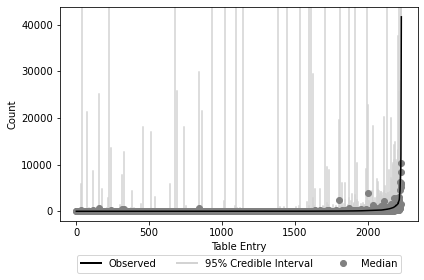

In [16]:
import birdman.visualization as viz

viz.plot_posterior_predictive_checks(inference);

This model seems to do an okay job of predicting counts from metadata.

## Comparing to a null model

Similarly to Songbird we can compare our fitted regression model to a "null" model with only an intercept.

In [17]:
from birdman import NegativeBinomial

nb_null = NegativeBinomial(
    table=filt_tbl,
    formula="1",
    metadata=metadata,
    num_iter=100,
    chains=4
)
nb_null.compile_model()
nb_null.fit_model()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/gibs/projects/birdman/birdman/templates/negative_binomial
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


In [18]:
inference_null = nb_null.to_inference_object(
    params=["beta", "phi"],
    coords={
        "feature": nb_null.feature_names,
        "covariate": nb_null.colnames
    },
    dims={
        "beta": ["covariate", "feature"],
        "phi": ["feature"]
    },
    alr_params=["beta"],
    posterior_predictive="y_predict",
    log_likelihood="log_lik",
    include_observed_data=True
)

We can look at use `birdman.diagnostics.loo` again to see how our predictive power is with this null model.

In [20]:
diag.loo(inference_null, pointwise=True)

Computed from 400 by 2233 log-likelihood matrix

         Estimate       SE
elpd_loo -8213.90   106.47
p_loo      155.41        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2179   97.6%
 (0.5, 0.7]   (ok)         44    2.0%
   (0.7, 1]   (bad)         9    0.4%
   (1, Inf)   (very bad)    1    0.0%

We see a lower value of `elpd_loo`, indicating that this null model has less predictive power than our regression model.

Another thing we can do is use the `arviz.compare` function to compare multiple models. This function takes a dictionary in the form of `{"model_1": InferenceObject, ...}` and outputs a table where the models are ranked from "best" at the top to "worst" at the bottom.

In [21]:
import arviz as az

az.compare({"null": inference_null, "model": inference})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model,0,-8081.017922,345.231629,0.000000,0.78918,105.563684,0.000000,True,log
null,1,-8213.895754,155.409370,132.877831,0.21082,106.472978,24.534732,True,log


We see that indeed our regression model is at the top. We can also compare the difference in `elpd` relative to the standard error to get a rough idea of how much better this model is.

In [22]:
(-8081.017922 - -8213.895754) / 105.563684

1.2587456875794447

Looks like this model is about 1.25 SE above the null. Not bad!

# Analyzing differentials

We are now ready to use our fitted parameters for further analysis.

We can now plot our parameter estimates similarly to how we would do a rank-plot in Qurro. However, since in the Bayesian framework each parameter has a distribution, we also include the standard deviation of these parameter estimates.

In [23]:
nb.colnames

Index(['Intercept', 'C(diet, Treatment('Control'))[T.DIO]',
       'C(treatment, Treatment('Ad Lib'))[T.Weight Reduced]',
       'C(diet, Treatment('Control'))[T.DIO]:C(treatment, Treatment('Ad Lib'))[T.Weight Reduced]'],
      dtype='object')

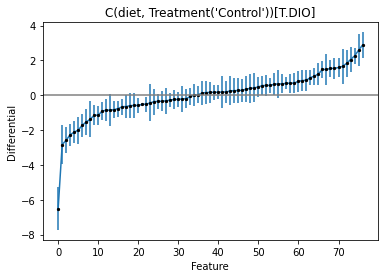

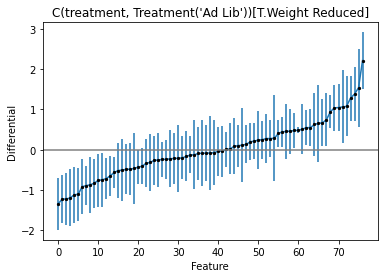

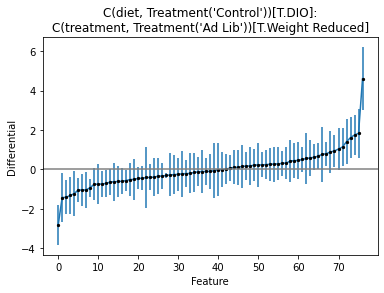

In [24]:
for col in nb.colnames[1:]:
    ax = viz.plot_parameter_estimates(
        inference,
        parameter="beta",
        coord={"covariate": col}
    )
    ax.set_title(":\n".join(col.split(":")))
    ax.axhline(y=0, color="gray")

We can use these differentials in the same ways as Songbird. Let's focus on the diet differentials - first we have to sort the features by their means across all chains and draws. This is fairly straightforward using `xarray`-style indexing.

In [31]:
diet_diffs = inference.posterior["beta"].sel({"covariate": "C(diet, Treatment('Control'))[T.DIO]"})
diet_diffs = diet_diffs.stack(mcmc_sample=("chain", "draw"))
diet_diffs_means = diet_diffs.mean(dim="mcmc_sample")
diet_diffs_means = diet_diffs_means.sortby(diet_diffs_means)
diet_diffs_means

<xarray.DataArray 'beta' (feature: 77)>
array([-6.50844098, -2.83345046, -2.57633943, -2.26600157, -2.1184095 ,
       -2.00175768, -1.7238043 , -1.53378994, -1.37665901, -1.14323644,
       -1.1426962 , -0.90569316, -0.85394244, -0.85106406, -0.82259995,
       -0.76334052, -0.65462412, -0.64856105, -0.59189951, -0.58669796,
       -0.57933152, -0.51891376, -0.50419003, -0.43693897, -0.35994595,
       -0.34898597, -0.34002159, -0.31427469, -0.27148863, -0.24071901,
       -0.23666375, -0.2059449 , -0.19130198, -0.06706002,  0.00856607,
        0.0352095 ,  0.13713841,  0.15670261,  0.17115887,  0.17435892,
        0.17712442,  0.18934076,  0.1927691 ,  0.25951163,  0.26425183,
        0.27863558,  0.2800825 ,  0.36501562,  0.39355095,  0.42959577,
        0.48191963,  0.55952733,  0.56167889,  0.57102841,  0.6400369 ,
        0.65359658,  0.65551026,  0.69278096,  0.6957235 ,  0.7037455 ,
        0.80888971,  0.84354921,  0.8699352 ,  1.01806812,  1.10000834,
        1.23329158,  1.48312449,  1.48339042,  1.54378709,  1.54459594,
        1.59759445,  1.66075334,  1.82838215,  2.0503741 ,  2.25859082,
        2.58213483,  2.88375877])
Coordinates:
  * feature    (feature) object '230759' '193831' ... '1684221' '258522'
    covariate  <U36 "C(diet, Treatment('Control'))[T.DIO]"

## Plotting log-ratios

Finally, we'll calculate log-ratios using autoselected OTUs. We'll take the top and bottom 5 OTUs to use as our numerator and denominator respectively.

In [34]:
import numpy as np

def log_ratio(table, top_feats, bot_feats):
    num_df = table.loc[:, top_feats].sum(axis=1).to_frame()# + 1
    num_df.columns = ["num"]
    num_df = num_df[num_df["num"] > 0]
    denom_df = table.loc[:, bot_feats].sum(axis=1).to_frame()# + 1
    denom_df.columns = ["denom"]
    denom_df = denom_df[denom_df["denom"] > 0]
    lr_df = num_df.join(denom_df, how="inner")
    lr_df["log_ratio"] = np.log(lr_df["num"]/lr_df["denom"])
    return lr_df

In [35]:
bottom_otus = diet_diffs_means[:5].coords["feature"].values
top_otus = diet_diffs_means[-5:].coords["feature"].values

lr_df = log_ratio(filt_tbl_df.T, top_otus, bottom_otus).join(metadata, how="inner")
print(lr_df.shape)
lr_df.head()

(28, 59)


,num,denom,log_ratio,adiponectin,altitude,anonymized_name,b_cell_function_measure,body_habitat,body_product,body_site,...,saa3,sample_type,slc25a,t3,t4,title,tnfa,total_ee,total_number_of_synapses,treatment
107.CM04,415.0,1248.0,-1.101019,23.55,0,sample03,280.7,UBERON:feces,UBERON:feces,UBERON:feces,...,2.24,XXQIITAXX,1.01,15.30,57.87,Leptin levels correlate with the composition o...,1.17,11.70,19.06,Weight Reduced
107.CM10,1889.0,223.0,2.136631,31.19,0,sample11,222.5,UBERON:feces,UBERON:feces,UBERON:feces,...,1.05,XXQIITAXX,0.87,38.90,56.13,Leptin levels correlate with the composition o...,2.22,13.93,15.82,Ad Lib
107.CM19,1148.0,50976.0,-3.793334,22.85,0,sample25,93.7,UBERON:feces,UBERON:feces,UBERON:feces,...,0.00,XXQIITAXX,0.66,8.80,50.95,Leptin levels correlate with the composition o...,1.67,12.28,14.27,Ad Lib
107.CM23,167.0,37841.0,-5.423155,14.35,0,sample27,140.0,UBERON:feces,UBERON:feces,UBERON:feces,...,0.01,XXQIITAXX,0.59,54.04,42.76,Leptin levels correlate with the composition o...,2.07,12.43,20.92,Ad Lib
107.CM28,20.0,1205.0,-4.098503,40.49,0,sample21,183.8,UBERON:feces,UBERON:feces,UBERON:feces,...,0.15,XXQIITAXX,0.49,13.42,43.39,Leptin levels correlate with the composition o...,0.80,7.37,30.64,Weight Reduced


We'll now plot these log-ratios and compare them by diet.

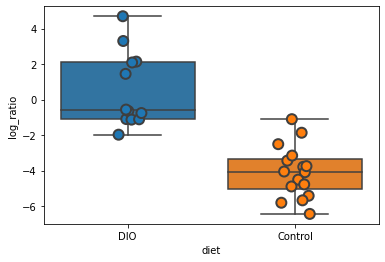

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

args = {
    "data": lr_df,
    "x": "diet",
    "y": "log_ratio"
}

sns.boxplot(**args)
sns.stripplot(**args, linewidth=2, size=10)

plt.show()

In [37]:
import scipy.stats as ss

dio_samples = lr_df.query("diet == 'DIO'")["log_ratio"]
control_samples = lr_df.query("diet == 'Control'")["log_ratio"]

print(ss.mannwhitneyu(dio_samples, control_samples))

MannwhitneyuResult(statistic=4.0, pvalue=1.0794920920558321e-05)


Indeed, this log-ratio separates the samples well by diet.

We can also use the Hotelling t-Test on individual covariates to see if they are centered around 0 (in ALR coordinates).

In [38]:
from birdman.stats import hotelling_ttest

hotelling_ttest(inference, {"covariate": "C(diet, Treatment('Control'))[T.DIO]"})

(532.9167686100052, 1.1102230246251565e-16)